In [1]:
import tensorflow as tf
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import backend as K
import keras
from IPython.display import clear_output
import pandas as pd
from sklearn.utils import shuffle
from sklearn.neighbors import KDTree
from tqdm import trange, tqdm
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Я пользовался неполным датасетом (т.к. полный очень долго pair'ится): взял по 130тыс каждого класса

In [ ]:
A = 500000
df = pd.read_csv('HIGGS.csv.gz')
X_all = df.as_matrix()[:A, 1:]
y_all = df.as_matrix()[:A, 0]
zeros = X_all[y_all==0]
ones = X_all[y_all==1]
ones = ones[len(ones)//2:]
DATA_SHAPE = [-1, 28]

In [ ]:
kdtree = KDTree(zeros, leaf_size=16)
indx = np.ones(shape=(ones.shape[0]), dtype='int64') * (-1)
used_points = set()
for i in tqdm(np.random.permutation(ones.shape[0])):
    match_found = False
    k = 10
    
    while not match_found:
        js = kdtree.query(ones[i, :].reshape(1, -1), k=k, return_distance=False)[0]
        for j in js:
            if not j in used_points:
                used_points.add(j)
                indx[i] = j
                match_found = True
                break
        k += 10

100%|██████████| 132352/132352 [1:16:32<00:00, 28.82it/s]


In [4]:
X_TRAIN = np.append(zeros[indx], ones, axis=0)
Y_TRAIN = np.array([[0]]*len(indx) + [[1]]*len(ones))
PAIRS = np.stack([zeros[indx], ones], axis=1)

In [5]:
class NN(Sequential):
    def __init__(self):

        super().__init__([
            Dense(5, input_shape=(28,), activation='relu'),
            Dense(1, activation='sigmoid')
            ])

        self.compile(loss='binary_crossentropy',
                      optimizer=keras.optimizers.Adam(),
                      metrics=['accuracy'])
        
        # цель этой части кода - определть self.grads, вычисляющую градиент на переданном батче
        y_ = K.placeholder([None, 1])
        y_pred = self.output
        simple_loss = K.binary_crossentropy(output=y_pred, target=y_)
        self.grads = K.function([self.input, y_], K.gradients(simple_loss, self.weights))
        
        # опряделяем array'и-вероятности (мне было удобно хранить их именно как часть сети)
        self.probs_paired_case = np.array([(1 / len(PAIRS))]*len(PAIRS))
        self.consts_paired_case = np.array([1]*len(PAIRS))
        self.probs_not_paired_case = np.array([(1 / len(X_TRAIN))]*len(X_TRAIN))
        self.consts_not_paired_case = np.array([1]*len(X_TRAIN))
        
    def recompute_probs_and_consts(self, is_paired_case):
        """
        пересчитывает вероятности сэмплинга элементов X_TRAIN в случае
        когда is_paired_case == False, или же вероятности сэмплинга элементов
        PAIRS в случае is_paired_case=True
        """
        
        if is_paired_case:
            probs = self.probs_paired_case
            consts = self.consts_paired_case
        else:
            probs = self.probs_not_paired_case
            consts = self.consts_not_paired_case

        def get_G(x, y):
            def l2_norm_of_list_of_arrays(list_of_arrays):
                output = np.concatenate([elem.flatten() for elem in list_of_arrays])
                output = output.reshape(-1)
                return np.linalg.norm(output)
            
            def grads_on_elem(x, y):
                return self.grads([x, y])
            return l2_norm_of_list_of_arrays(grads_on_elem(x ,y))

        if is_paired_case:
            probs = np.array([get_G(elem, np.array([[0], [1]])) + 1e-8 for elem in PAIRS], dtype='float64')
            probs = probs / probs.sum()
            probs = np.clip(probs, a_min=(1 / len(PAIRS))/50, a_max=(1 / len(PAIRS))*50)
            probs = probs / probs.sum()
            consts = (1 / len(PAIRS)) * (1 / probs)
        else:
            probs = np.array([get_G(X_TRAIN[i].reshape(*DATA_SHAPE), Y_TRAIN[i].reshape(1,1)) + 1e-8 for i in range(len(X_TRAIN))], dtype='float64')
            probs = probs / probs.sum()
            probs = np.clip(probs, a_min=(1 / len(X_TRAIN))/50, a_max=(1 / len(X_TRAIN))*50)
            probs = probs / probs.sum()
            consts = (1 / len(X_TRAIN)) * (1 / probs)
       

In [6]:
sess = tf.Session()
K.set_session(sess)

Всё, что происходит далее, сделано для ручного обучения keras моделей tf'ом.

placeholder'ы **labels** и **constants** общие для всех моделей.

**nn_uniform**: модель, которая обучается равномерным сэмплингом из **X_TRAIN**.

**nn_discrete_paired_IS**: модель, которая обучается сэмплингом из **PAIRS** в соответствии с распределением, которое пересчитывается раз в 5 эпох (поэтому и слово discrete, т.к. не постоянно обновляются вероятности/константы)

**nn_adaptive_paired_IS**: модель, которая обучается сэмплингом из **PAIRS** в соответствии с распределением, которое пересчитывается в процессе обучения на тех объектах, которые попали в батч на текущем шаге

**nn_discrete_IS**: то же самое, что и **nn_discrete_paired_IS**, только сэмплим не из **PAIRS**, а из **X_TRAIN**

**nn_adaptive_IS**: то же самое, что и **nn_adaptive_paired_IS**, только сэмплим не из **PAIRS**, а из **X_TRAIN**

In [7]:
labels = tf.placeholder(tf.float32, shape=(None, 1))
constants = tf.placeholder(tf.float32, shape=(None, 1))

nn_uniform = NN()
loss_uniform = K.mean(K.binary_crossentropy(labels, nn_uniform.output), axis=-1)
train_step_uniform = tf.train.AdamOptimizer().minimize(loss_uniform)

nn_discrete_paired_IS = NN()
loss_discrete_paired_IS = K.mean(constants * K.binary_crossentropy(labels, nn_discrete_paired_IS.output), axis=-1)
train_step_discrete_paired_IS = tf.train.AdamOptimizer().minimize(loss_discrete_paired_IS)

nn_adaptive_paired_IS = NN()
loss_adaptive_paired_IS = K.mean(constants * K.binary_crossentropy(labels, nn_adaptive_paired_IS.output), axis=-1)
train_step_adaptive_paired_IS = tf.train.AdamOptimizer().minimize(loss_adaptive_paired_IS)

nn_discrete_IS = NN()
loss_discrete_IS = K.mean(constants * K.binary_crossentropy(labels, nn_discrete_IS.output), axis=-1)
train_step_discrete_IS = tf.train.AdamOptimizer().minimize(loss_discrete_IS)

nn_adaptive_IS = NN()
loss_adaptive_IS = K.mean(constants * K.binary_crossentropy(labels, nn_adaptive_IS.output), axis=-1)
train_step_adaptive_IS = tf.train.AdamOptimizer().minimize(loss_adaptive_IS)

init_op = tf.global_variables_initializer()
sess.run(init_op)

nn_uniform.fit(X_TRAIN, Y_TRAIN, epochs=1)

nn_uniform.save_weights('weights')
nn_discrete_paired_IS.load_weights('weights')
nn_adaptive_paired_IS.load_weights('weights')
nn_discrete_IS.load_weights('weights')
nn_adaptive_IS.load_weights('weights')

Epoch 1/1
264704/264704 [==============================] - 28s 104us/step - loss: 0.6824 - acc: 0.5603


Определим сэмплеры. Названия соответствуют соответствующим нейросетям.

In [8]:
def generate_uniform(nn, batch_size=512):
    while True:
        inds = np.random.choice(len(X_TRAIN), size=[batch_size])
        current_x = X_TRAIN[inds]
        current_y = Y_TRAIN[inds]
        current_x = current_x.reshape(*DATA_SHAPE)
        current_y = current_y.reshape(-1,1)
        yield {nn.input:current_x, labels:current_y}
        
def generate_discrete_IS(nn, batch_size=512): 
    while True:
        inds = np.random.choice(len(X_TRAIN), size=[batch_size], p=nn.probs_not_paired_case)
        current_x = X_TRAIN[inds]
        current_y = Y_TRAIN[inds]
        current_c = np.array([nn.consts_not_paired_case[i] for i in inds])
        current_x = current_x.reshape(*DATA_SHAPE)
        current_y = current_y.reshape(-1,1)
        current_c = current_c.reshape(-1,1)
        yield {nn.input:current_x, constants:current_c, labels:current_y}
        
def generate_discrete_paired_IS(nn, batch_size=512):
    while True:
        inds = np.random.choice(len(PAIRS), size=[batch_size // 2], p=nn.probs_paired_case)
        current_x = PAIRS[inds]
        current_y = np.array([[0,1] for _ in current_x])
        current_c = np.array([[nn.consts_paired_case[i], nn.consts_paired_case[i]] for i in inds])
        current_x = current_x.reshape(*DATA_SHAPE)
        current_y = current_y.reshape(-1,1)
        current_c = current_c.reshape(-1,1)
        yield {nn.input:current_x, constants:current_c, labels:current_y}

def generate_adaptive_paired_IS(nn, batch_size=512):
    
    def get_G(pair):
            def l2_norm_of_list_of_arrays(list_of_arrays):
                output = np.concatenate([elem.flatten() for elem in list_of_arrays])
                output = output.reshape(-1)
                return np.linalg.norm(output)
            
            def grads_on_pair(pair):
                return nn.grads([pair.reshape(*DATA_SHAPE),
                                np.array([1,1]).reshape(-1,1),
                                np.array([0,1]).reshape(-1,1)])
            return l2_norm_of_list_of_arrays(grads_on_pair(pair))

    while True:
        inds = np.random.choice(len(PAIRS), size=[batch_size // 2], p=nn.probs_paired_case)
        current_x = PAIRS[inds]
        current_y = np.array([[0,1] for _ in current_x])
        current_c = np.array([[nn.consts_paired_case[i], nn.consts_paired_case[i]] for i in inds])
        
        nn.probs_paired_case[inds] = np.array([get_G(pair) + 1e-8 for pair in current_x], dtype='float64')
        nn.probs_paired_case = nn.probs_paired_case / nn.probs_paired_case.sum()
        nn.probs_paired_case = np.clip(nn.probs_paired_case, a_min=(1 / len(PAIRS))/50, a_max=(1 / len(PAIRS))*50)
        nn.probs_paired_case = nn.probs_paired_case / nn.probs_paired_case.sum()
        nn.consts_paired_case = (1 / len(PAIRS)) * (1 / nn.probs_paired_case)
        
        current_x = current_x.reshape(*DATA_SHAPE)
        current_y = current_y.reshape(-1,1)
        current_c = current_c.reshape(-1,1)
        yield {nn.input:current_x, constants:current_c, labels:current_y}
        
def generate_adaptive_IS(nn, batch_size=512):
    
    def get_G(x, y):
            def l2_norm_of_list_of_arrays(list_of_arrays):
                output = np.concatenate([elem.flatten() for elem in list_of_arrays])
                output = output.reshape(-1)
                return np.linalg.norm(output)
            
            def grads_on_elem(x, y):
                return nn.grads([x, y])
            return l2_norm_of_list_of_arrays(grads_on_elem(x ,y))

    while True:
        inds = np.random.choice(len(X_TRAIN), size=[batch_size // 2], p=nn.probs_not_paired_case)
        current_x = X_TRAIN[inds]
        current_y = Y_TRAIN[inds]
        current_c = np.array([nn.consts_not_paired_case[i] for i in inds])
        
        nn.probs_not_paired_case[inds] = np.array([get_G(X_TRAIN[i].reshape(*DATA_SHAPE), Y_TRAIN[i].reshape(1,1)) + 1e-8 for pair in current_x], dtype='float64')
        nn.probs_not_paired_case = nn.probs_not_paired_case / nn.probs_not_paired_case.sum()
        nn.probs_not_paired_case = np.clip(nn.probs_not_paired_case, a_min=(1 / len(X_TRAIN))/50, a_max=(1 / len(X_TRAIN))*50)
        nn.probs_not_paired_case = nn.probs_not_paired_case / nn.probs_not_paired_case.sum()
        nn.consts_not_paired_case = (1 / len(X_TRAIN)) * (1 / nn.probs_not_paired_case)
        
        current_x = current_x.reshape(*DATA_SHAPE)
        current_y = current_y.reshape(-1,1)
        current_c = current_c.reshape(-1,1)
        yield {nn.input:current_x, constants:current_c, labels:current_y}

remark: 

$\cdot$ пока что пользовался adam'ом

$\cdot$ обучение будет с минибатчами (т.е. adaptive-методы не бесплатные в этом случае даже теоретически). 

$\cdot$ Моя реализация не делает бесплатными adaptive-методы даже в случае чистого SGD без минибатчей, исправлю это, если потребуется

In [12]:
uniform = []
with sess.as_default():
    for ep in trange(50):
        for i in range(100):
            _, l =sess.run([train_step_uniform, loss_uniform], feed_dict=next(generate_uniform(nn_uniform, batch_size=64)))
        uniform.append(nn_uniform.evaluate(X_TRAIN, Y_TRAIN, verbose=False, batch_size=128)[0])

100%|██████████| 30/30 [01:15<00:00,  2.52s/it]


In [13]:
adaptive_paired = []
with sess.as_default():
    for ep in trange(50):
        for i in range(100):
            _, l =sess.run([train_step_adaptive_paired_IS, loss_adaptive_paired_IS],
                           feed_dict=next(generate_adaptive_paired_IS(nn_adaptive_paired_IS, batch_size=64)))
        adaptive_paired.append(nn_adaptive_paired_IS.evaluate(X_TRAIN, Y_TRAIN, verbose=False)[0])

100%|██████████| 30/30 [06:57<00:00, 13.91s/it]


In [15]:
adaptive = []
with sess.as_default():
    for ep in trange(50):
        for i in range(100):
            _, l =sess.run([train_step_adaptive_IS, loss_adaptive_IS],
                           feed_dict=next(generate_adaptive_IS(nn_adaptive_IS, batch_size=64)))
        adaptive.append(nn_adaptive_IS.evaluate(X_TRAIN, Y_TRAIN, verbose=False, batch_size=128)[0])

100%|██████████| 50/50 [06:10<00:00,  7.40s/it]


In [ ]:
discrete = []
with sess.as_default():
    for ep in trange(50):
        if ep % 5 == 0: nn_discrete_IS.recompute_probs_and_consts(False)
        for i in range(100):
            _, l =sess.run([train_step_discrete_IS, loss_discrete_IS],
                           feed_dict=next(generate_discrete_IS(nn_discrete_IS, batch_size=64)))
        discrete.append(nn_discrete_IS.evaluate(X_TRAIN, Y_TRAIN, verbose=False, batch_size=128)[0])

 50%|█████     | 10/20 [13:03<13:03, 78.35s/it]  

In [ ]:
discrete_paired = []
with sess.as_default():
    for ep in trange(20):
        if ep % 5 == 0: nn_discrete_paired_IS.recompute_probs_and_consts(False)
        for i in range(100):
            _, l =sess.run([train_step_discrete_paired_IS, loss_discrete_paired_IS],
                           feed_dict=next(generate_discrete_paired_IS(nn_discrete_paired_IS, batch_size=64)))
        discrete_paired.append(nn_discrete_paired_IS.evaluate(X_TRAIN, Y_TRAIN, verbose=False, batch_size=128)[0])

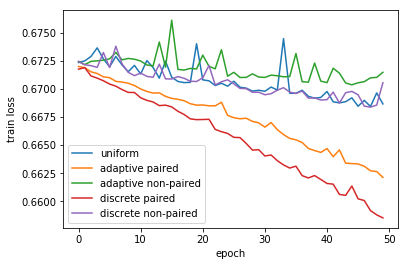

In [24]:
plt.plot(uniform, label='uniform')
plt.plot(adaptive_paired, label='adaptive paired')
plt.plot(adaptive, label='adaptive non-paired')
plt.plot(discrete_paired, label='discrete paired')
plt.plot(discrete, label='discrete non-paired ')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show()

Выводы: paired-методы обучаются быстрее, чем обычные не-paired: успех.